In [1]:
import re
from pathlib import Path
import pickle
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
from nltk.metrics.distance import edit_distance

from morphological_tagging.metrics import RunningStats

EVAL_FILES_PATH = "./morphological_tagging/eval"

models = ["UDPipe2", "DogTag"]

lang_stats = defaultdict(dict)

In [38]:
eval_data = defaultdict(lambda: dict())
eval_stats = defaultdict(lambda: dict())
for model in models:
    for eval_fp in Path(EVAL_FILES_PATH).glob(f"**/{model}*.pickle"):
        lang = re.search(r"_([A-Z][a-z]+)_", eval_fp.parts[-1]).group(1)

        if eval_data[model].get(lang, True):
            data = []
            with open(eval_fp, "rb") as fr:
                try:
                    while True:
                        data.append(pickle.load(fr))
                except EOFError:
                    pass

            eval_data[model][lang] = data[:-1]
            eval_stats[model][lang] = data[-1]

        else:
            print(f"Language {lang} already processed, skipping.")

In [39]:
langs = sorted(list({lang for sys in eval_data.keys() for lang in eval_data[sys].keys()}))
N_langs = len(langs)

In [40]:
# Are all the languages here?
langs

['Arabic',
 'Czech',
 'Dutch',
 'English',
 'Finnish',
 'French',
 'Russian',
 'Turkish']

# OOV Performance

How well do the model work on new word-forms and new lemmas? Here we test this for each model/language combination individually, and compare across models. For details see corresponding thesis chapter.

In [370]:
import pandas as pd
import scipy.stats as stats

def mean_diff(a, b):
    return np.mean(a) - np.mean(b)

def pooled_std(a, b):
    return np.sqrt((np.var(a) * (len(a) - 1) + np.var(b) * (len(b) - 1)) / (len(a) - len(b) - 2))

def pooled_se(a, b):
    pooled_se_ = pooled_std(a, b) * np.sqrt(1/len(a) + 1/len(b))

    return pooled_se_

def pooled_df(a, b):
    return len(a) + len(b) - 2

def cohen_var(a, b, d):
    return 1 / len(a) + 1 / len(b) + (d ** 2) / (2 * (len(a) + len(b)))

def build_df(stats_records):

    df = pd.DataFrame.from_records(stats_records)
    df = df.set_index("language")

    systems_df = []
    for system in list(eval_data.keys()):
        df_system = df[df["system"] == system]
        df_system.columns = pd.MultiIndex.from_tuples([
            ("", "", "System"),
            ("Lemma Acc.", system, "Seen"),
            ("Lemma Acc.", system, "Unseen"),
            ("Lemma Acc.", system, "d"),
            ("Lemma Acc.", system, "d_std"),
            ("Lev. Dist.", system, "Seen"),
            ("Lev. Dist.", system, "Unseen"),
            ("Lev. Dist.", system, "d"),
            ("Lev. Dist.", system, "d_std"),
            ("Morph. Acc.", system, "Seen"),
            ("Morph. Acc.", system, "Unseen"),
            ("Morph. Acc.", system, "d"),
            ("Morph. Acc.", system, "d_std"),
            ("Morph. IoU", system, "Seen"),
            ("Morph. IoU", system, "Unseen"),
            ("Morph. IoU", system, "d"),
            ("Morph. IoU", system, "d_std"),
            ])

        df_system = df_system.drop(("", "", "System"), axis=1)
        df_system = df_system#.reset_index()

        systems_df.append(df_system)

    df = pd.concat(systems_df, axis=1)
    df = df[sorted([col for i in range(len(systems_df)) for col in systems_df[i].columns], key=lambda x: x[0])]#.reset_index(drop=True)

    systems = list(eval_data.keys())
    for metric in df.columns.levels[0]:

        df[metric, "Diff", "z"] = (df[metric][systems[0]]["d"] - df[metric][systems[1]]["d"]) \
            / np.sqrt(df[metric][systems[0]]["d_std"] + df[metric][systems[1]]["d_std"])

        p = df[metric, "Diff", "z"].map(lambda zz: f"{np.round(stats.norm.sf(np.abs(zz)), 5):.2e}")

        df[metric, "Diff", "p"] = p.map(lambda pp: "-" if pp == "0.00e+00" else pp)

    df = df[sorted([col for col in df.columns if "d_std" not in col], key=lambda x: x[0])]#.reset_index(drop=True)

    return df

conditioned_stats_wf = []
conditioned_stats_lemma = []

for system in list(eval_data.keys()):

    for lang in langs:

        N_tokens = 0

        lemma_acc_all = []
        lev_dist_all = []
        morph_acc_all = []
        morph_iou_all = []

        lemma_acc_seen_wf = []
        lev_dist_seen_wf = []
        morph_acc_seen_wf = []
        morph_iou_seen_wf = []

        lemma_acc_seen_lemma = []
        lev_dist_seen_lemma = []
        morph_acc_seen_lemma = []
        morph_iou_seen_lemma = []

        lemma_acc_unseen_wf = []
        lev_dist_unseen_wf = []
        morph_acc_unseen_wf = []
        morph_iou_unseen_wf = []

        lemma_acc_unseen_lemma = []
        lev_dist_unseen_lemma = []
        morph_acc_unseen_lemma = []
        morph_iou_unseen_lemma = []
        for token in eval_data[system][lang]:
            lemma_acc = int(token[1] == token[2])
            lev_dist = edit_distance(token[1], token[2])
            morph_acc = int(token[5] == token[6])
            morph_tag_iou = len(set.intersection(token[5], token[6])) / len(set.union(token[5], token[6]))

            lemma_acc_all += [lemma_acc]
            lev_dist_all += [lev_dist]
            morph_acc_all += [morph_acc]
            morph_iou_all += [morph_tag_iou]

            if token[-2]:
                # Have seen the word form
                lemma_acc_seen_wf += [lemma_acc]
                lev_dist_seen_wf += [lev_dist]
                morph_acc_seen_wf += [morph_acc]
                morph_iou_seen_wf += [morph_tag_iou]
            elif token[-1]:
                # Have not seen the word form, but have seen the lemma
                lemma_acc_unseen_wf += [lemma_acc]
                lev_dist_unseen_wf += [lev_dist]
                morph_acc_unseen_wf += [morph_acc]
                morph_iou_unseen_wf += [morph_tag_iou]

            if (token[-2] or token[-1]):
                # Have seen the lemma
                lemma_acc_seen_lemma += [lemma_acc]
                lev_dist_seen_lemma += [lev_dist]
                morph_acc_seen_lemma += [morph_acc]
                morph_iou_seen_lemma += [morph_tag_iou]
            else:
                # Have not seen the lemma
                lemma_acc_unseen_lemma += [lemma_acc]
                lev_dist_unseen_lemma += [lev_dist]
                morph_acc_unseen_lemma += [morph_acc]
                morph_iou_unseen_lemma += [morph_tag_iou]

            N_tokens += 1

        lemma_acc_wf_cohen_d = mean_diff(lemma_acc_seen_wf, lemma_acc_unseen_wf) / pooled_std(lemma_acc_seen_wf, lemma_acc_unseen_wf)
        lemma_acc_wf_cohen_d_std = cohen_var(lemma_acc_seen_wf, lemma_acc_unseen_wf, lemma_acc_wf_cohen_d)
        lemma_acc_lemma_cohen_d = mean_diff(lemma_acc_seen_lemma, lemma_acc_unseen_lemma) / pooled_std(lemma_acc_seen_lemma, lemma_acc_unseen_lemma)
        lemma_acc_lemma_cohen_d_std = cohen_var(lemma_acc_seen_lemma, lemma_acc_unseen_lemma, lemma_acc_lemma_cohen_d)

        lev_dist_wf_cohen_d = mean_diff(lev_dist_seen_wf, lev_dist_unseen_wf) / pooled_std(lev_dist_seen_wf, lev_dist_unseen_wf)
        lev_dist_wf_cohen_d_std = cohen_var(lev_dist_seen_wf, lev_dist_unseen_wf, lev_dist_wf_cohen_d)
        lev_dist_lemma_cohen_d = mean_diff(lev_dist_seen_lemma, lev_dist_unseen_lemma) / pooled_std(lev_dist_seen_lemma, lev_dist_unseen_lemma)
        lev_dist_lemma_cohen_d_std = cohen_var(lev_dist_seen_lemma, lev_dist_unseen_lemma, lev_dist_lemma_cohen_d)

        morph_acc_wf_cohen_d = mean_diff(morph_acc_seen_wf, morph_acc_unseen_wf) / pooled_std(morph_acc_seen_wf, morph_acc_unseen_wf)
        morph_acc_wf_cohen_d_std = cohen_var(morph_acc_seen_wf, morph_acc_unseen_wf, morph_acc_wf_cohen_d)
        morph_acc_lemma_cohen_d = mean_diff(morph_acc_seen_lemma, morph_acc_unseen_lemma) / pooled_std(morph_acc_seen_lemma, morph_acc_unseen_lemma)
        morph_acc_lemma_cohen_d_std = cohen_var(morph_acc_seen_lemma, morph_acc_unseen_lemma, morph_acc_lemma_cohen_d)

        morph_iou_wf_cohen_d = mean_diff(morph_iou_seen_wf, morph_iou_unseen_wf) / pooled_std(morph_iou_seen_wf, morph_iou_unseen_wf)
        morph_iou_wf_cohen_d_std = cohen_var(morph_iou_seen_wf, morph_iou_unseen_wf, morph_iou_wf_cohen_d)
        morph_iou_lemma_cohen_d = mean_diff(morph_iou_seen_lemma, morph_iou_unseen_lemma) / pooled_std(morph_iou_seen_lemma, morph_iou_unseen_lemma)
        morph_iou_lemma_cohen_d_std = cohen_var(morph_iou_seen_lemma, morph_iou_unseen_lemma, morph_iou_lemma_cohen_d)

        conditioned_stats_wf.append({
            "language": lang,
            "system": system,
            "lemma_acc_seen_wf": np.mean(lemma_acc_seen_wf),
            "lemma_acc_unseen_wf": np.mean(lemma_acc_unseen_wf),
            "lemma_acc_wf_cohen_d": lemma_acc_wf_cohen_d,
            "lemma_acc_wf_cohen_d_std": lemma_acc_wf_cohen_d_std,
            "lev_dist_seen_wf": np.mean(lev_dist_seen_wf),
            "lev_dist_unseen_wf": np.mean(lev_dist_unseen_wf),
            "lev_dist_wf_cohen_d": lev_dist_wf_cohen_d,
            "lev_dist_wf_cohen_d_std": lev_dist_wf_cohen_d_std,
            "morph_acc_seen_wf": np.mean(morph_acc_seen_wf),
            "morph_acc_unseen_wf": np.mean(morph_acc_unseen_wf),
            "morph_acc_wf_cohen_d": morph_acc_wf_cohen_d,
            "morph_acc_wf_cohen_d_std": morph_acc_wf_cohen_d_std,
            "morph_iou_seen_wf": np.mean(morph_iou_seen_wf),
            "morph_iou_unseen_wf": np.mean(morph_iou_unseen_wf),
            "morph_iou_wf_cohen_d": morph_iou_wf_cohen_d,
            "morph_iou_wf_cohen_d_std": morph_iou_wf_cohen_d_std,

        })

        conditioned_stats_lemma.append({
            "language": lang,
            "system": system,
            "lemma_acc_seen_lemma": np.mean(lemma_acc_seen_lemma),
            "lemma_acc_unseen_lemma": np.mean(lemma_acc_unseen_lemma),
            "lemma_acc_lemma_cohen_d": lemma_acc_lemma_cohen_d,
            "lemma_acc_lemma_cohen_d_std": lemma_acc_lemma_cohen_d_std,
            "lev_dist_seen_lemma": np.mean(lev_dist_seen_lemma),
            "lev_dist_unseen_lemma": np.mean(lev_dist_unseen_lemma),
            "lev_dist_lemma_cohen_d": lev_dist_lemma_cohen_d,
            "lev_dist_lemma_cohen_d_std": lev_dist_lemma_cohen_d_std,
            "morph_acc_seen_lemma": np.mean(morph_acc_seen_lemma),
            "morph_acc_unseen_lemma": np.mean(morph_acc_unseen_lemma),
            "morph_acc_lemma_cohen_d": morph_acc_lemma_cohen_d,
            "morph_acc_lemma_cohen_d_std": morph_acc_lemma_cohen_d_std,
            "morph_iou_seen_lemma": np.mean(morph_iou_seen_lemma),
            "morph_iou_unseen_lemma": np.mean(morph_iou_unseen_lemma),
            "morph_iou_lemma_cohen_d": morph_iou_lemma_cohen_d,
            "morph_iou_lemma_cohen_d_std": morph_iou_lemma_cohen_d_std,
        })


In [374]:
df_wf = build_df(conditioned_stats_wf)[["Lev. Dist.", "Morph. IoU"]].round(2)
df_wf = df_wf[sorted([col for col in df_wf.columns if "z" not in col], key=lambda x: x[0])]
df_wf

Lev. Dist.                                            Morph. IoU  \
            UDPipe2              DogTag                   Diff    UDPipe2   
               Seen Unseen     d   Seen Unseen     d         p       Seen   
language                                                                    
Arabic         0.11   2.09 -2.71   0.11   1.74 -2.17         -       0.96   
Czech          0.01   0.34 -1.22   0.02   0.16 -0.54         -       0.98   
Dutch          0.04   0.91 -2.01   0.06   0.65 -1.18         -       0.97   
English        0.03   0.44 -1.25   0.05   0.51 -1.13  6.35e-03       0.95   
Finnish        0.10   1.36 -1.41   0.09   0.77 -0.85         -       0.94   
French         0.03   0.54 -1.50   0.04   0.35 -0.92         -       0.96   
Russian        0.03   0.44 -1.00   0.05   0.29 -0.56         -       0.97   
Turkish        0.09   0.96 -1.27   0.13   0.56 -0.61         -       0.89   

                                                     
                      DogTag                   Diff  
         Unseen     d   Seen Unseen     d         p  
language                                             
Arabic     0.88  0.48   0.95   0.81  0.70         -  
Czech      0.91  0.57   0.96   0.91  0.41         -  
Dutch      0.84  0.79   0.96   0.79  0.80  4.12e-01  
English    0.84  0.61   0.93   0.76  0.71  1.73e-02  
Finnish    0.78  0.72   0.94   0.84  0.43         -  
French     0.89  0.48   0.96   0.88  0.47  3.85e-01  
Russian    0.92  0.27   0.95   0.91  0.22  4.30e-04  
Turkish    0.71  0.62   0.88   0.79  0.31         -

In [375]:
df_lemma = build_df(conditioned_stats_lemma)[["Lev. Dist.", "Morph. IoU"]].round(2)
df_lemma = df_lemma[sorted([col for col in df_lemma.columns if "z" not in col], key=lambda x: x[0])]
df_lemma

Lev. Dist.                                            Morph. IoU  \
            UDPipe2              DogTag                   Diff    UDPipe2   
               Seen Unseen     d   Seen Unseen     d         p       Seen   
language                                                                    
Arabic         0.17   1.56 -1.58   0.17   1.34 -1.37  1.00e-05       0.96   
Czech          0.03   0.22 -0.70   0.03   0.17 -0.53         -       0.97   
Dutch          0.06   0.72 -1.09   0.08   0.64 -0.89         -       0.97   
English        0.04   0.20 -0.45   0.06   0.23 -0.39  1.38e-02       0.95   
Finnish        0.28   1.68 -1.20   0.19   1.08 -0.95         -       0.92   
French         0.04   0.18 -0.41   0.04   0.16 -0.35  8.93e-02       0.96   
Russian        0.05   0.32 -0.62   0.06   0.28 -0.51         -       0.96   
Turkish        0.17   1.08 -1.24   0.16   1.02 -1.18  6.58e-02       0.88   

                                                     
                      DogTag                   Diff  
         Unseen     d   Seen Unseen     d         p  
language                                             
Arabic     0.76  1.08   0.94   0.70  1.15  7.45e-02  
Czech      0.87  0.79   0.96   0.85  0.76  7.25e-02  
Dutch      0.85  0.62   0.95   0.80  0.64  3.04e-01  
English    0.86  0.45   0.93   0.80  0.50  4.79e-02  
Finnish    0.82  0.41   0.93   0.86  0.27         -  
French     0.84  0.75   0.96   0.82  0.76  3.44e-01  
Russian    0.86  0.66   0.94   0.81  0.72  1.08e-03  
Turkish    0.71  0.58   0.87   0.71  0.55  1.72e-01

In [377]:
print(
    df_lemma[["Lev. Dist.", "Morph. IoU"]].to_latex(
        float_format="%.2f",
        bold_rows=False,
        escape=False,
        multicolumn=True,
        multirow=True,
        multicolumn_format="c",
    )
)


\begin{tabular}{lrrrrrrlrrrrrrl}
\toprule
{} & \multicolumn{7}{c}{Lev. Dist.} & \multicolumn{7}{c}{Morph. IoU} \\
{} & \multicolumn{3}{c}{UDPipe2} & \multicolumn{3}{c}{DogTag} &      Diff & \multicolumn{3}{c}{UDPipe2} & \multicolumn{3}{c}{DogTag} &      Diff \\
{} &       Seen & Unseen &     d &   Seen & Unseen &     d &         p &       Seen & Unseen &    d &   Seen & Unseen &    d &         p \\
language &            &        &       &        &        &       &           &            &        &      &        &        &      &           \\
\midrule
Arabic   &       0.17 &   1.56 & -1.58 &   0.17 &   1.34 & -1.37 &  1.00e-05 &       0.96 &   0.76 & 1.08 &   0.94 &   0.70 & 1.15 &  7.45e-02 \\
Czech    &       0.03 &   0.22 & -0.70 &   0.03 &   0.17 & -0.53 &         - &       0.97 &   0.87 & 0.79 &   0.96 &   0.85 & 0.76 &  7.25e-02 \\
Dutch    &       0.06 &   0.72 & -1.09 &   0.08 &   0.64 & -0.89 &         - &       0.97 &   0.85 & 0.62 &   0.95 &   0.80 & 0.64 &  3.04e-01 \\
Engli

# Lemmatization

## Accuracy

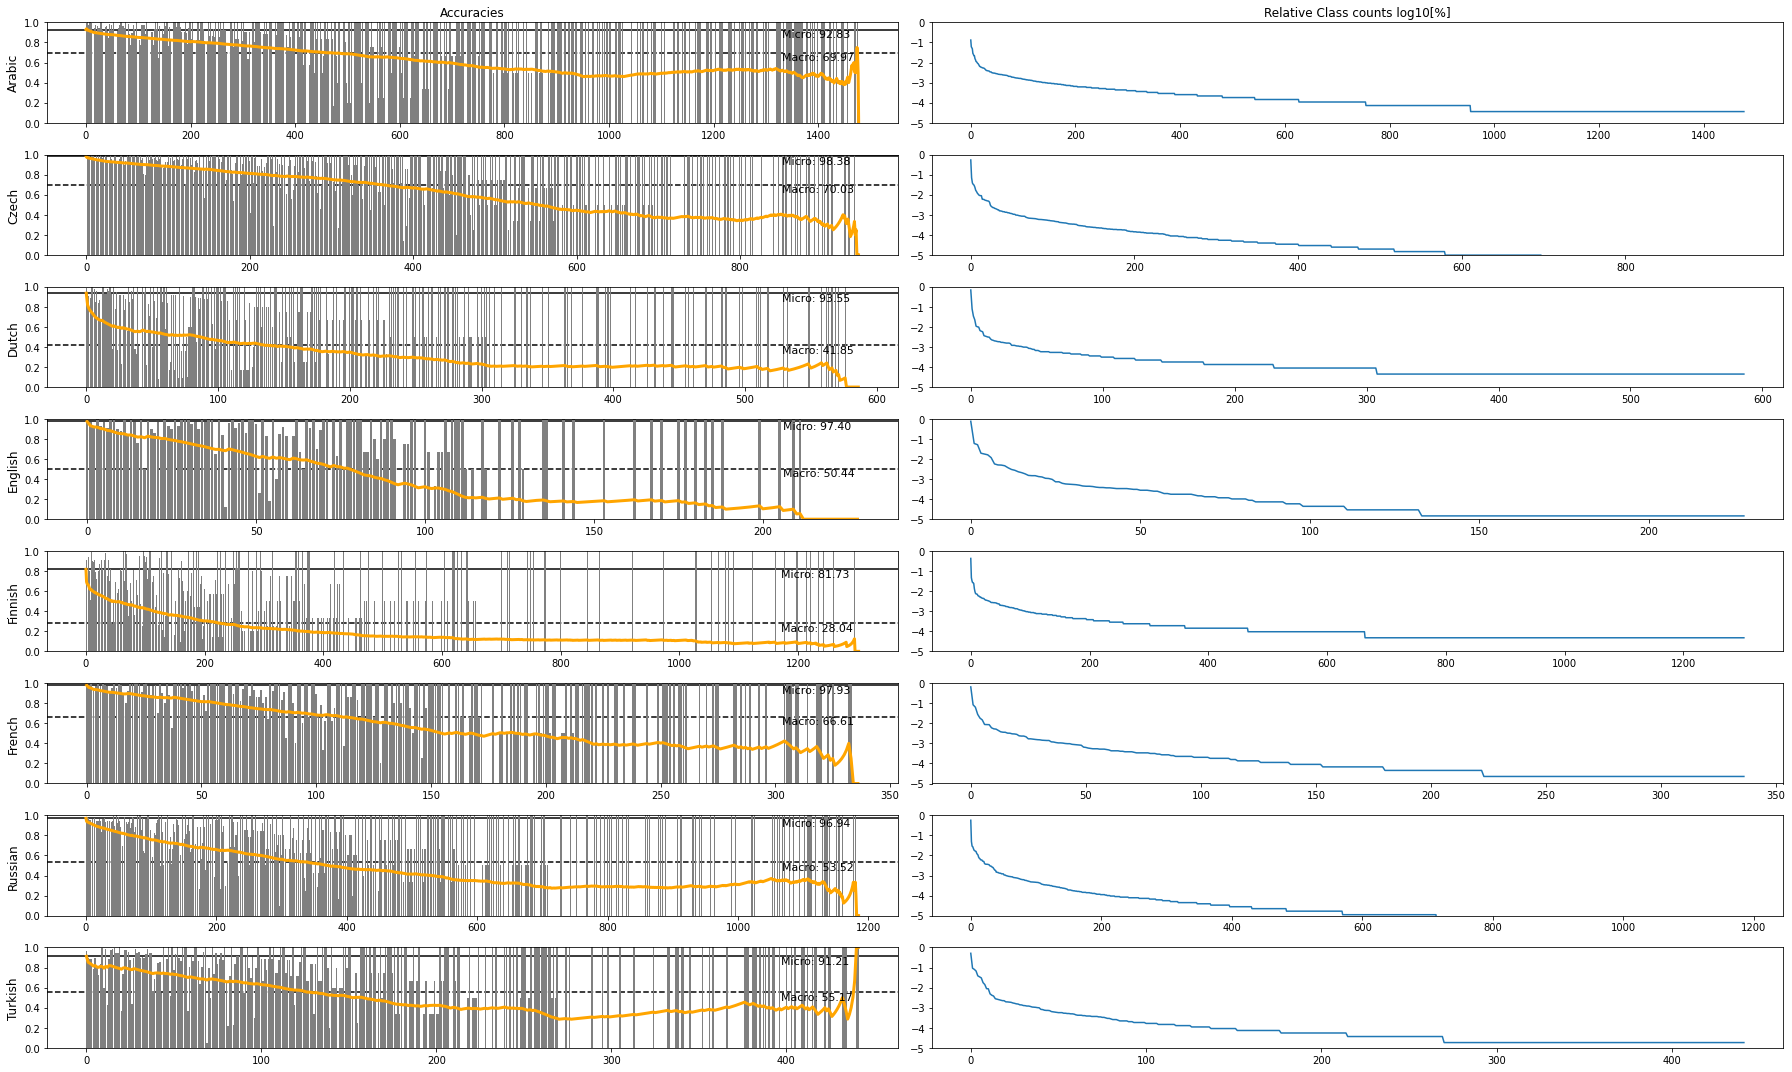

In [53]:
fig, axes = plt.subplots(ncols=2, nrows=N_langs, figsize=(25, 15))

for row, axes_row in enumerate(axes):

    acc_stats = defaultdict(RunningStats)
    for tok in eval_data[langs[row]]:
        acc_stats[tok[3]](int(tok[3] == tok[4]))
    acc_stats = dict(acc_stats)

    x, stats = list(map(list, zip(*sorted(acc_stats.items(), key=lambda x: x[1].N, reverse=True))))
    N, mean = np.array([s.N for s in stats]), np.array([s.mean for s in stats])

    micro_mean = np.sum(N * mean) / np.sum(N)
    macro_mean = np.mean(mean)

    for col, ax in enumerate(axes_row):

        if col == 0:
            # First column: accuracies

            # Barplot of accuracy per class
            ax.bar(np.arange(len(N)), mean, color='gray', zorder=0)

            # Plot micro-mean
            ax.axhline(y=micro_mean, c='black', ls='-', zorder=-1)
            ax.text(int(0.90 * len(N)), micro_mean-0.08, f'Micro: {micro_mean*100:.2f}', size=11, color='black')

            # Plot macro-mean
            ax.axhline(y=macro_mean, c='black', ls='--', zorder=-1)
            ax.text(int(0.90 * len(N)), macro_mean-0.08, f'Macro: {macro_mean*100:.2f}', size=11, color='black')

            # Plot micro-mean per excluded class
            micro_means = [np.sum(N[i:] * mean[i:]) / np.sum(N[i:]) for i in range(len(N))]
            ax.plot(micro_means, c='orange', zorder=1, linewidth=3)

            # Set titles and such
            if row == 0:
                ax.set_title("Accuracies", size=12)

            ax.set_ylabel(langs[row], size=12)

            ax.set_ylim(0.0, 1.0)

            lang_stats[langs[row]].update({
                "Lemma/Acc. Micro": micro_mean,
                "Lemma/Acc. Micro @ 2": micro_means[2],
                "Lemma/Acc. Micro @ 10": micro_means[10],
                "Lemma/Acc. Micro @ 100": micro_means[100],
                "Lemma/Acc. Macro": macro_mean,
            })

        if col == 1:
            # Second column: class occurence

            ax.plot(np.log10(N) - np.log10(np.sum(N)))

            if row == 0:
                ax.set_title("Relative Class counts log10[%]", size=12)

            ax.set_ylim(-5, 0)

    plt.tight_layout()

All languages perform poorly when lemma scripts become less frequent. The rate of decay, see gap between micro and macro averaged mean accuracies or the strength of the orange line, seems to be caused by the size of the training dataset and the complexity of the language (strongly correlated). Micro-averaged performance seems to be largely dominated by the most common classes, and in turn by the dataset size.

## Edit Distance

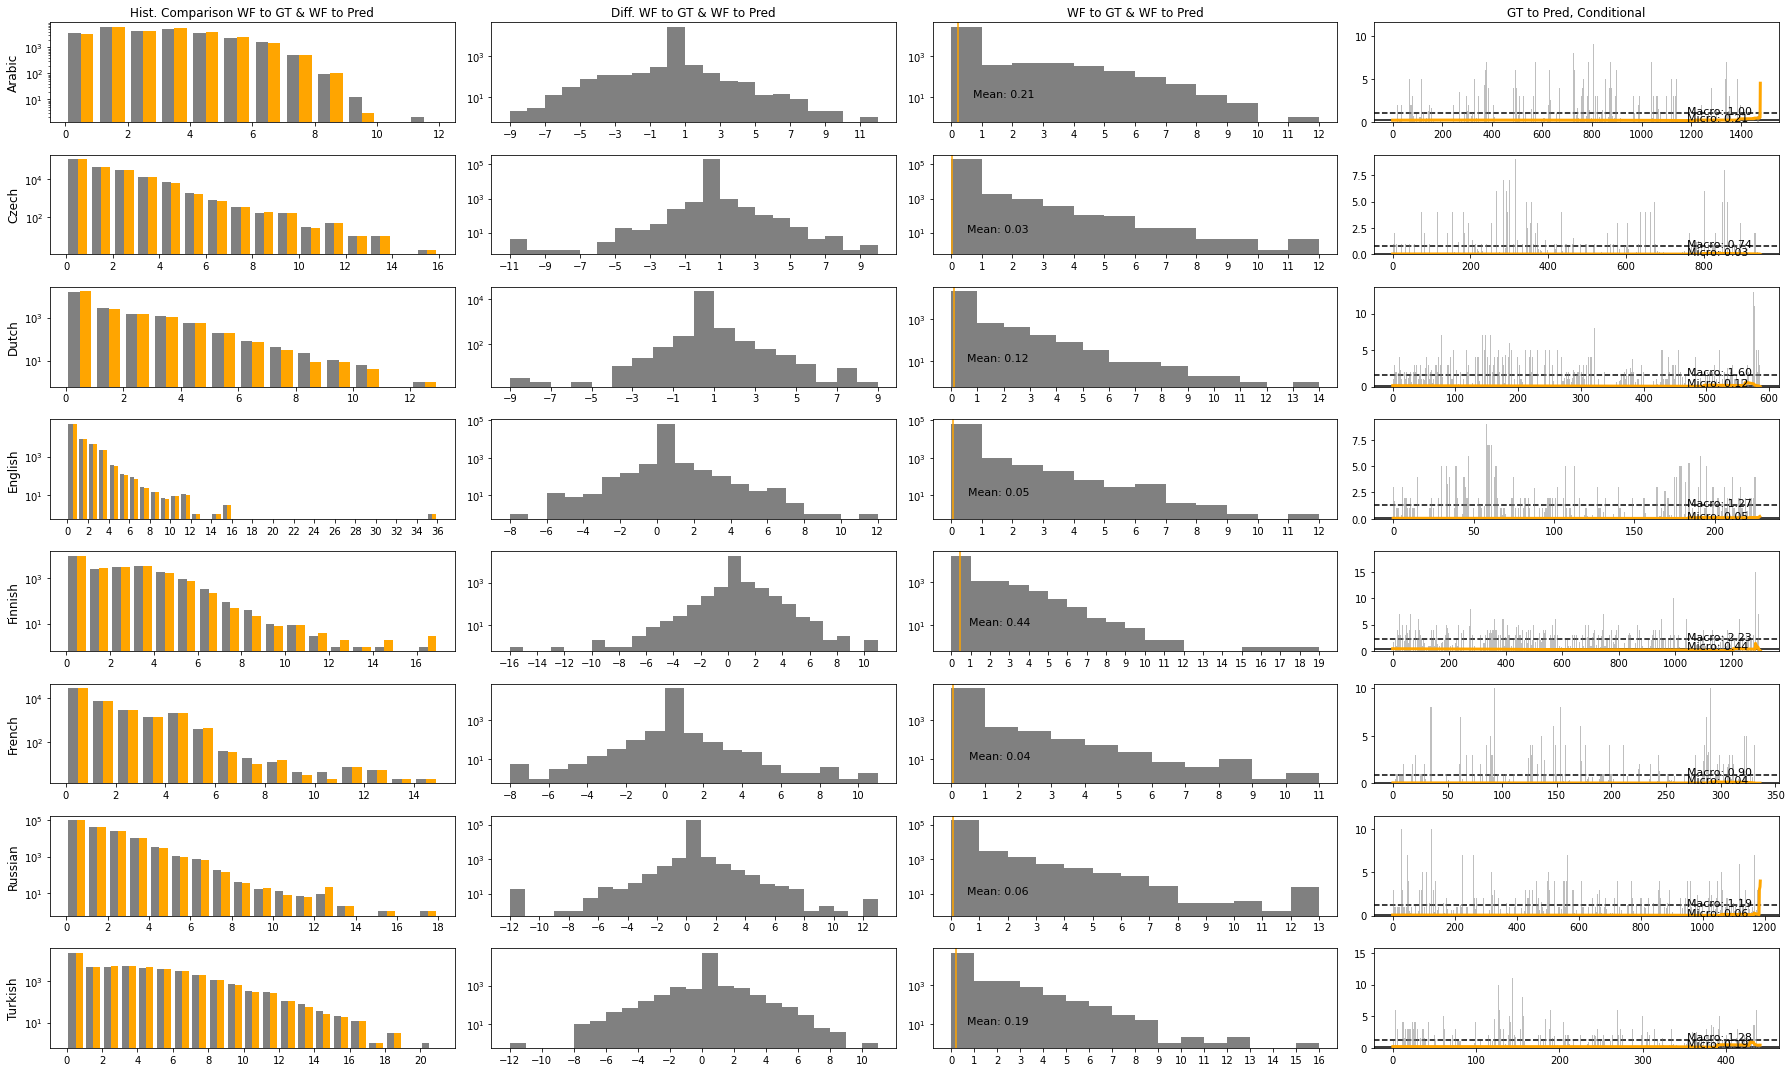

In [54]:
fig, axes = plt.subplots(nrows=N_langs, ncols=4, figsize=(25, 15))

for row, axes_row in enumerate(axes):

    dist_stats = []
    dist_stats_conditional = defaultdict(RunningStats)
    for tok in eval_data[langs[row]]:
        wf_to_lm = edit_distance(tok[0], tok[1])
        wf_to_out = edit_distance(tok[0], tok[2])
        lm_to_out = edit_distance(tok[1], tok[2])

        dist_stats.append([wf_to_lm, wf_to_out, wf_to_lm - wf_to_out, lm_to_out])
        dist_stats_conditional[tok[3]](lm_to_out)

    wf_to_lm, wf_to_out, wf_to_error, lm_to_out = list(map(list, zip(*dist_stats)))
    dist_stats_conditional = dict(dist_stats_conditional)

    for col, ax in enumerate(axes_row):

        if col == 0:
            ax.set_ylabel(langs[row], size=12)

            bins = np.linspace(0, np.max(wf_to_lm)+1, np.max(wf_to_lm)+2)

            ax.hist([wf_to_lm, wf_to_out], bins=bins, color=['gray', 'orange'])

            ax.set_xticks(bins[::2])
            ax.set_yscale("log")

            if row == 0:
                ax.set_title("Hist. Comparison WF to GT & WF to Pred", size=12)

        if col == 1:

            bins = np.linspace(np.min(wf_to_error), np.max(wf_to_error)+1, np.max(wf_to_error)-np.min(wf_to_error)+2)

            ax.hist(wf_to_error, bins=bins, color='gray')

            ax.set_xticks(bins[::2])
            ax.set_yscale("log")

            if row == 0:
                ax.set_title("Diff. WF to GT & WF to Pred", size=12)

        if col == 2:

            bins = np.linspace(0, np.max(lm_to_out)+1, np.max(lm_to_out)+2)

            ax.hist(lm_to_out, bins=bins, color='gray')

            # Plot mean
            mean = np.mean(lm_to_out)
            ax.axvline(x=mean, c='orange', ls='-', zorder=2)
            ax.text(mean+0.5, 10, f'Mean: {mean:.2f}', size=11, color='black')

            ax.set_xticks(bins)
            ax.set_yscale("log")

            if row == 0:
                ax.set_title("WF to GT & WF to Pred", size=12)

        if col == 3:

            x, stats = list(map(list, zip(*sorted(dist_stats_conditional.items(), key=lambda x: x[0]))))
            N, mean = np.array([s.N for s in stats]), np.array([s.mean for s in stats])

            micro_mean = np.sum(N * mean) / np.sum(N)
            macro_mean = np.mean(mean)

            # Barplot of accuracy per class
            ax.bar(np.arange(len(N)), mean, color='gray', zorder=0, alpha=0.5)

            # Plot micro-mean
            ax.axhline(y=micro_mean, c='black', ls='-', zorder=-1)
            ax.text(int(0.80 * len(N)), micro_mean-0.08, f'Micro: {micro_mean:.2f}', size=11, color='black')

            # Plot macro-mean
            ax.axhline(y=macro_mean, c='black', ls='--', zorder=-1)
            ax.text(int(0.80 * len(N)), macro_mean-0.08, f'Macro: {macro_mean:.2f}', size=11, color='black')

            # Plot micro-mean per excluded class
            ax.plot([np.sum(N[i:] * mean[i:]) / np.sum(N[i:]) for i in range(len(N))], c='orange', zorder=1, linewidth=3)

            # Set titles and such
            if row == 0:
                ax.set_title("GT to Pred, Conditional", size=12)

        lang_stats[langs[row]].update({
            "Lemma/Lev. Dist. Micro": micro_mean,
            "Lemma/Lev. Dist. Macro": macro_mean,
        })

plt.tight_layout()

### Vocab

In [55]:
set_of_lemmas = defaultdict(set)
set_of_pred_lemmas = defaultdict(set)

for lang in langs:
    for tok in eval_data[lang]:
        set_of_lemmas[lang].update([tok[1].lower()])
        set_of_pred_lemmas[lang].update([tok[2].lower()])

    lang_stats[lang].update({
        "Lemma/Vocab Growth": (len(set_of_pred_lemmas[lang]) - len(set_of_lemmas[lang])) / len(set_of_lemmas[lang])
        })

## Lemmatization Summary

In [56]:
df = pd.DataFrame.from_dict(lang_stats, orient="index")
df.columns = pd.MultiIndex.from_tuples([tuple(col_name.split("/")) for col_name in df.columns])

df

Lemma                                                             \
        Acc. Micro Acc. Micro @ 2 Acc. Micro @ 10 Acc. Micro @ 100 Acc. Macro   
Arabic    0.928306       0.931556        0.908490         0.850895   0.699745   
Czech     0.983790       0.968024        0.952184         0.882038   0.700332   
Dutch     0.935458       0.782682        0.669592         0.464832   0.418457   
English   0.973957       0.919654        0.852975         0.323699   0.504443   
Finnish   0.817340       0.673188        0.607900         0.426402   0.280449   
French    0.979300       0.950168        0.909220         0.683587   0.666073   
Russian   0.969425       0.935523        0.909962         0.757599   0.535215   
Turkish   0.912147       0.841749        0.793656         0.629893   0.551712   

                                                        
        Lev. Dist. Micro Lev. Dist. Macro Vocab Growth  
Arabic          0.214360         1.001859     0.113609  
Czech           0.029344         0.742897     0.047835  
Dutch           0.120661         1.597655     0.048340  
English         0.046828         1.269069     0.020127  
Finnish         0.435165         2.227742     0.313011  
French          0.040996         0.901801     0.018611  
Russian         0.059272         1.194173     0.071372  
Turkish         0.192022         1.276477     0.117909

# Overall & Morphological Tagging

In [43]:
stats_df = pd.DataFrame.from_dict(eval_stats, orient="index")
stats_df = stats_df.drop(columns=["morph_tag_f1"])

morph_tag_f1 = []
for micro, macro in zip(stats_df["morph_tag_f1_micro"].values, stats_df["morph_tag_f1_macro"].values):
    morph_tag_f1.append(f"{micro}/{macro}")
stats_df["Morph. Tag F1"] = morph_tag_f1

stats_df.columns = [
    "Lemma Acc.",
    "Lev. Dist.",
    "Morph. Set Acc.",
    "a",
    "b",
    "Tokens/second",
    "Morph. Tag F1 (micro/macro)"
]

stats_df = stats_df.drop(columns=["a"])
stats_df = stats_df.drop(columns=["b"])

cols = stats_df.columns.tolist()
cols_order = cols[:-2] + [cols[-1]] + [cols[-2]]

stats_df[cols_order]

,Lemma Acc.,Lev. Dist.,Morph. Set Acc.,Morph. Tag F1 (micro/macro),Tokens/second
Arabic,0.93 +- 1.54e-03,0.21 +- 5.32e-03,0.90 +- 1.81e-03,0.96/0.85,2313.08
Czech,0.98 +- 2.78e-04,0.03 +- 6.10e-04,0.92 +- 5.82e-04,0.98/0.90,2930.30
Dutch,0.94 +- 1.60e-03,0.12 +- 3.83e-03,0.95 +- 1.51e-03,0.97/0.93,3222.71
English,0.97 +- 6.07e-04,0.05 +- 1.33e-03,0.92 +- 1.01e-03,0.96/0.90,2976.70
Finnish,0.82 +- 2.64e-03,0.44 +- 7.71e-03,0.81 +- 2.69e-03,0.92/0.62,2632.62
French,0.98 +- 6.72e-04,0.04 +- 1.63e-03,0.92 +- 1.25e-03,0.97/0.87,3715.83
Russian,0.97 +- 4.05e-04,0.06 +- 9.90e-04,0.92 +- 6.40e-04,0.97/0.88,2759.40
Turkish,0.91 +- 1.21e-03,0.19 +- 3.13e-03,0.77 +- 1.80e-03,0.89/0.58,1828.43


In [46]:
eval_stats["Turkish"]["morph_tag_f1"]

[('PST+PRF', 'F1: 0.00 (0.00/0.00), N: 1'),
 ('INFM', 'F1: 0.00 (0.00/0.00), N: 2'),
 ('EQTV', 'F1: 0.00 (0.00/0.00), N: 5'),
 ('RECP', 'F1: 0.00 (0.00/0.00), N: 6'),
 ('PSSS', 'F1: 0.00 (0.00/0.00), N: 10'),
 ('V.MSDR', 'F1: 0.00 (0.00/0.00), N: 26'),
 ('INTJ', 'F1: 0.00 (0.00/0.00), N: 52'),
 ('OPT', 'F1: 0.00 (0.00/0.00), N: 81'),
 ('V.CVB', 'F1: 0.00 (0.00/0.00), N: 81'),
 ('COND', 'F1: 0.00 (0.00/0.00), N: 85'),
 ('PSS2P', 'F1: 0.00 (0.00/0.00), N: 97'),
 ('PSS2S', 'F1: 0.00 (0.00/0.00), N: 290'),
 ('PSS3P', 'F1: 0.01 (0.40/0.01), N: 291'),
 ('PSS1P', 'F1: 0.01 (0.40/0.01), N: 220'),
 ('NFH', 'F1: 0.03 (0.28/0.06), N: 125'),
 ('CAUS', 'F1: 0.11 (0.81/0.07), N: 191'),
 ('IPFV', 'F1: 0.22 (0.71/0.16), N: 129'),
 ('POT', 'F1: 0.22 (0.94/0.13), N: 127'),
 ('INS', 'F1: 0.28 (0.82/0.17), N: 418'),
 ('PSS1S', 'F1: 0.38 (0.86/0.24), N: 469'),
 ('FUT', 'F1: 0.38 (0.79/0.25), N: 255'),
 ('FH', 'F1: 0.56 (0.44/0.75), N: 377'),
 ('NEG', 'F1: 0.59 (0.74/0.49), N: 717'),
 ('V.PTCP', 'F1: 0.61 (